## Technical Analysis

In [1]:
import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import prophet
import matplotlib.pyplot as plt
import ta
from tabulate import tabulate
import warnings 
warnings.filterwarnings('ignore')

C:\Users\tanks\anaconda3\envs\DAB300\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"]=[14,8]

[*********************100%***********************]  1 of 1 completed


<AxesSubplot: title={'center': "Johnson & Johnson's stock in 2022"}, xlabel='Date'>

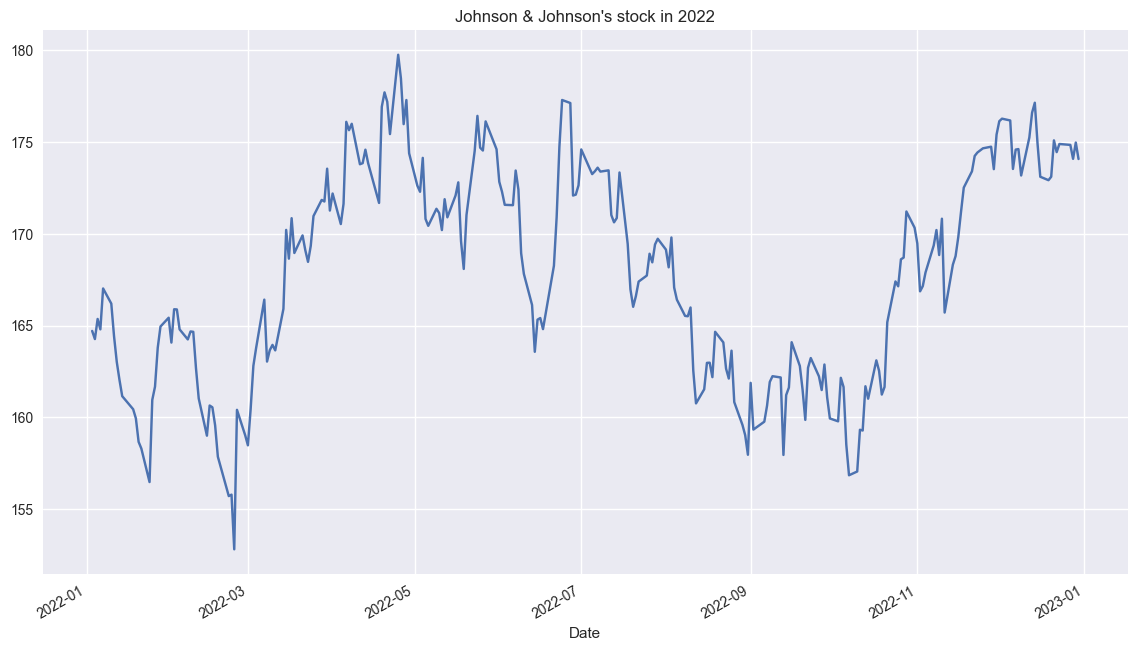

In [3]:
df=yf.download("JNJ",
               start="2022-01-01",
               end="2022-12-31")

df["Adj Close"].plot(title="Johnson & Johnson's stock in 2022")

### Bollinger Bands

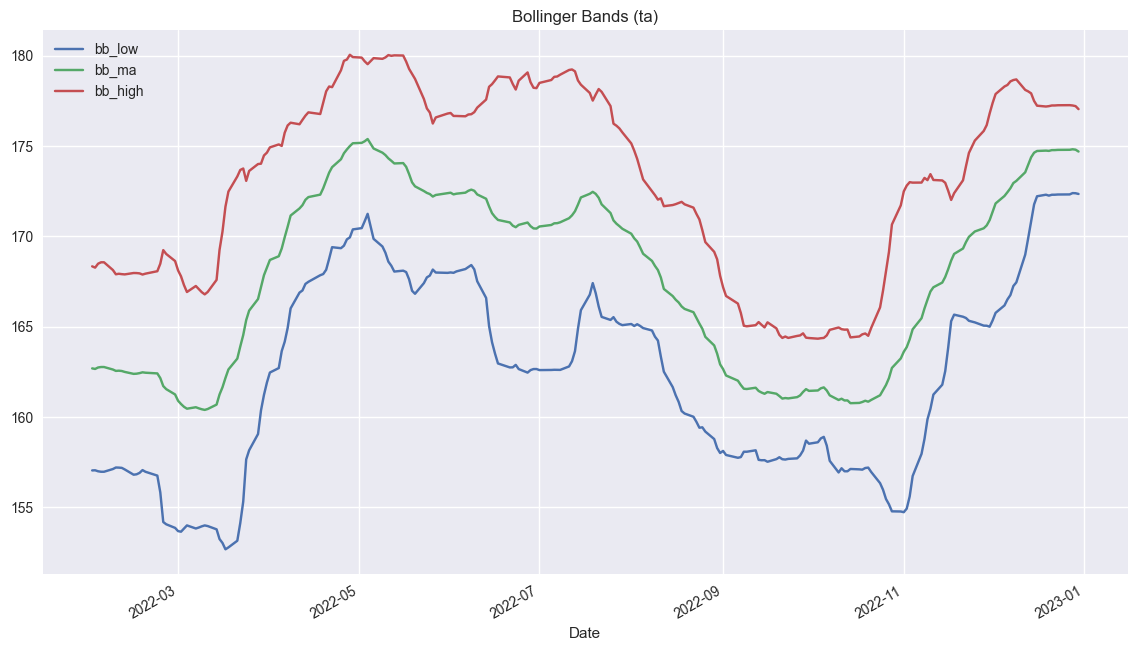

In [4]:
ta_bbands=ta.volatility.BollingerBands(close=df["Adj Close"],
                                       window=20,
                                       window_dev=2)
ta_df= df.copy()
ta_df["bb_ma"]=ta_bbands.bollinger_mavg()
ta_df["bb_high"]=ta_bbands.bollinger_hband()
ta_df["bb_low"]=ta_bbands.bollinger_lband()
ta_df[["bb_low","bb_ma","bb_high"]].plot(title="Bollinger Bands (ta)");

## Stock Signals

In [5]:
myticker = 'JNJ'
mydata = pd.DataFrame()
mydata[myticker] = yf.download(myticker,start="2022-01-01",end="2022-12-31")["Adj Close"]
mydata.columns = {'Close Price'}
mydata.head(10)

[*********************100%***********************]  1 of 1 completed


,Close Price
Date,
2022-01-03,164.712036
2022-01-04,164.270355
2022-01-05,165.364975
2022-01-06,164.798462
2022-01-07,167.026108
2022-01-10,166.200348
2022-01-11,164.433578
2022-01-12,163.031693
2022-01-13,162.042694


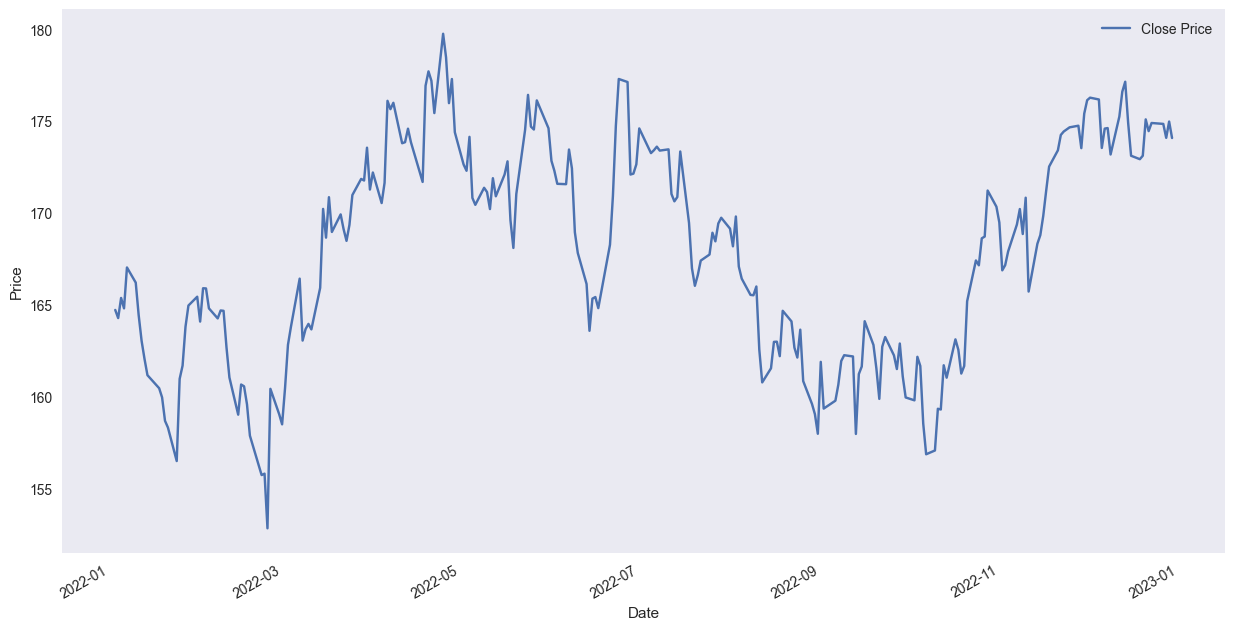

In [6]:
mydata.plot(figsize=(15,8))
plt.grid()
plt.ylabel('Price')
plt.show()

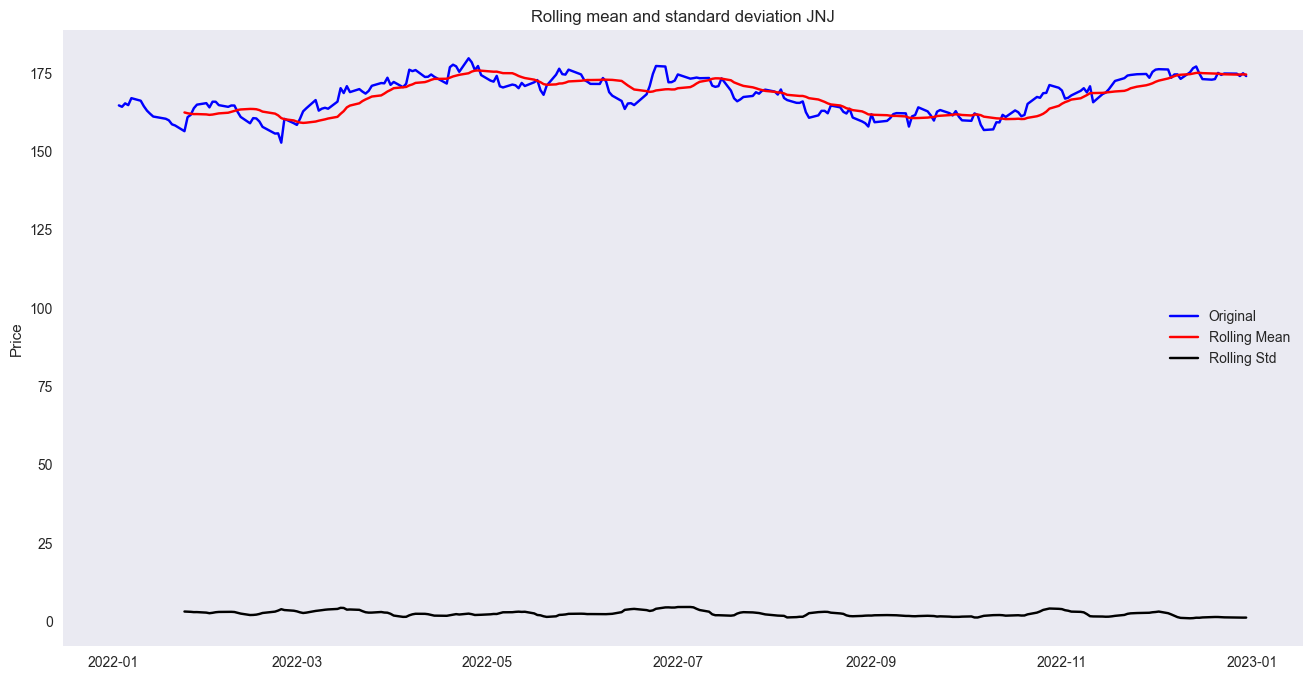

In [7]:
rolling_mean = mydata['Close Price'].rolling (15).mean()
rolling_std = mydata['Close Price'].rolling (15).std()
plt.figure(figsize = (16, 8))
fig=plt.figure(1)
orig = plt.plot(mydata['Close Price'], color='blue', label='Original')
mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')

std = plt.plot(rolling_std,color='black', label='Rolling Std')
plt.legend (loc='best')
plt.title('Rolling mean and standard deviation ' + myticker)
plt.grid()
plt.ylabel("Price")
plt.show()

In [8]:
# 30-day moving average as the short-term MA
mydata['sma30'] = mydata['Close Price'].rolling(window = 30, min_periods = 1).mean()
# 90-day moving average as the Long-term MA
mydata['sma90'] = mydata['Close Price'].rolling(window = 90, min_periods = 1).mean()
mydata.head(15)

,Close Price,sma30,sma90
Date,,,
2022-01-03,164.712036,164.712036,164.712036
2022-01-04,164.270355,164.491196,164.491196
2022-01-05,165.364975,164.782455,164.782455
2022-01-06,164.798462,164.786457,164.786457
2022-01-07,167.026108,165.234387,165.234387
2022-01-10,166.200348,165.395381,165.395381
2022-01-11,164.433578,165.257980,165.257980
2022-01-12,163.031693,164.979694,164.979694
2022-01-13,162.042694,164.653361,164.653361


In [9]:
mydata['Signal'] =  0.0
mydata['Signal'] = np.where(mydata['sma30']> mydata['sma90'],1.0,0.0)

In [10]:
mydata['Position'] = mydata['Signal'].diff()
mydata.head(15)

,Close Price,sma30,sma90,Signal,Position
Date,,,,,
2022-01-03,164.712036,164.712036,164.712036,0.0,NaN
2022-01-04,164.270355,164.491196,164.491196,0.0,0.0
2022-01-05,165.364975,164.782455,164.782455,0.0,0.0
2022-01-06,164.798462,164.786457,164.786457,0.0,0.0
2022-01-07,167.026108,165.234387,165.234387,0.0,0.0
2022-01-10,166.200348,165.395381,165.395381,0.0,0.0
2022-01-11,164.433578,165.257980,165.257980,0.0,0.0
2022-01-12,163.031693,164.979694,164.979694,0.0,0.0
2022-01-13,162.042694,164.653361,164.653361,0.0,0.0


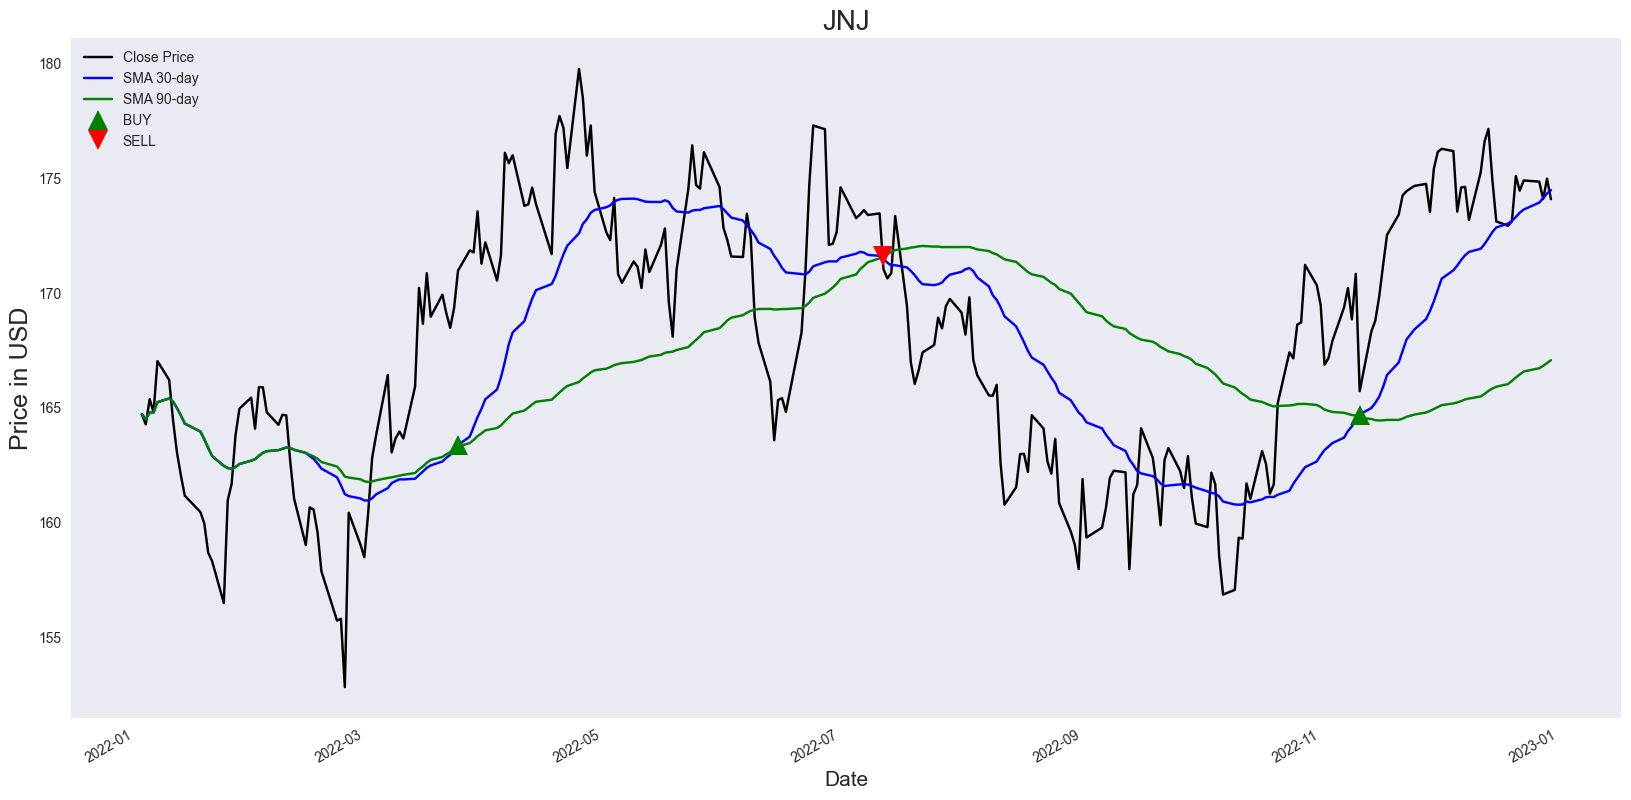

In [11]:
plt.figure(figsize = (20,10))
# plot close price, short-term and long-term moving averages
mydata['Close Price'].plot(color = 'k', label= 'Close Price')
mydata['sma30'].plot(color = 'b', label = 'SMA 30-day ')
mydata['sma90'].plot(color='g', label = 'SMA 90-day ')
# plot buy signals
plt.plot(mydata[mydata['Position'] == 1].index,
mydata['sma30'][mydata['Position'] == 1], '^', markersize = 15, color = 'g', label = 'BUY')
# plot 'sell' signals
plt.plot(mydata[mydata['Position'] == -1].index,
mydata['sma90'][mydata['Position'] == -1], 'v', markersize = 15, color = 'r', label = 'SELL') 
plt.ylabel('Price in USD', fontsize = 18 )
plt.xlabel('Date', fontsize= 15 )
plt.title(myticker, fontsize = 20)
plt.legend()
plt.grid()
plt.show()

In [12]:
df_position = mydata[ (mydata['Position'] == 1) | (mydata['Position'] == -1)] 
df_position['Position'] = df_position['Position'].apply(lambda x: 'Buy' if x == 1 else 'Sell') 
print(tabulate(df_position, headers = 'keys', tablefmt = 'psql'))

+---------------------+---------------+---------+---------+----------+------------+
| Date                |   Close Price |   sma30 |   sma90 |   Signal | Position   |
|---------------------+---------------+---------+---------+----------+------------|
| 2022-03-25 00:00:00 |       170.968 | 163.371 | 163.307 |        1 | Buy        |
| 2022-07-12 00:00:00 |       171.026 | 171.494 | 171.617 |        0 | Sell       |
| 2022-11-11 00:00:00 |       165.713 | 164.697 | 164.559 |        1 | Buy        |
+---------------------+---------------+---------+---------+----------+------------+


### EXPONENTIAL MOVING AVERAGE

In [13]:
myticker2 = 'JNJ'
mydata2 = pd.DataFrame()
mydata2[myticker2] = yf.download(myticker2,start="2022-01-01",end="2022-12-31")["Adj Close"]
mydata2.columns = {'Close Price'}
mydata2.head(10)

[*********************100%***********************]  1 of 1 completed


,Close Price
Date,
2022-01-03,164.712051
2022-01-04,164.270355
2022-01-05,165.364990
2022-01-06,164.798462
2022-01-07,167.026093
2022-01-10,166.200333
2022-01-11,164.433578
2022-01-12,163.031708
2022-01-13,162.042694


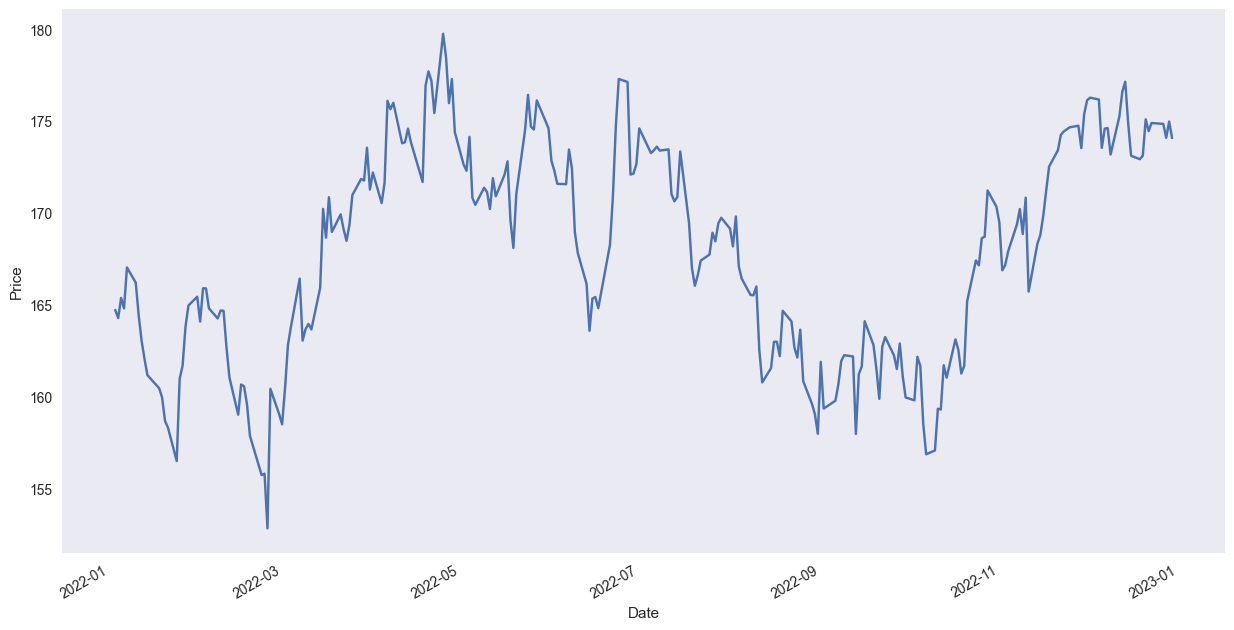

In [14]:
mydata2['Close Price'].plot(figsize=(15,8))
plt.grid()
plt.ylabel('Price')
plt.show()

In [15]:
mydata2['EMA30'] = mydata2['Close Price'].ewm(span = 30, adjust=False ).mean()
mydata2['EMA90'] = mydata2['Close Price'].ewm(span = 900, adjust=False ).mean()
mydata2['Signal'] =  0.0
mydata2['Signal'] = np.where(mydata2['EMA30']> mydata2['EMA90'],1.0,0.0)
mydata2['Position'] = mydata2['Signal'].diff()

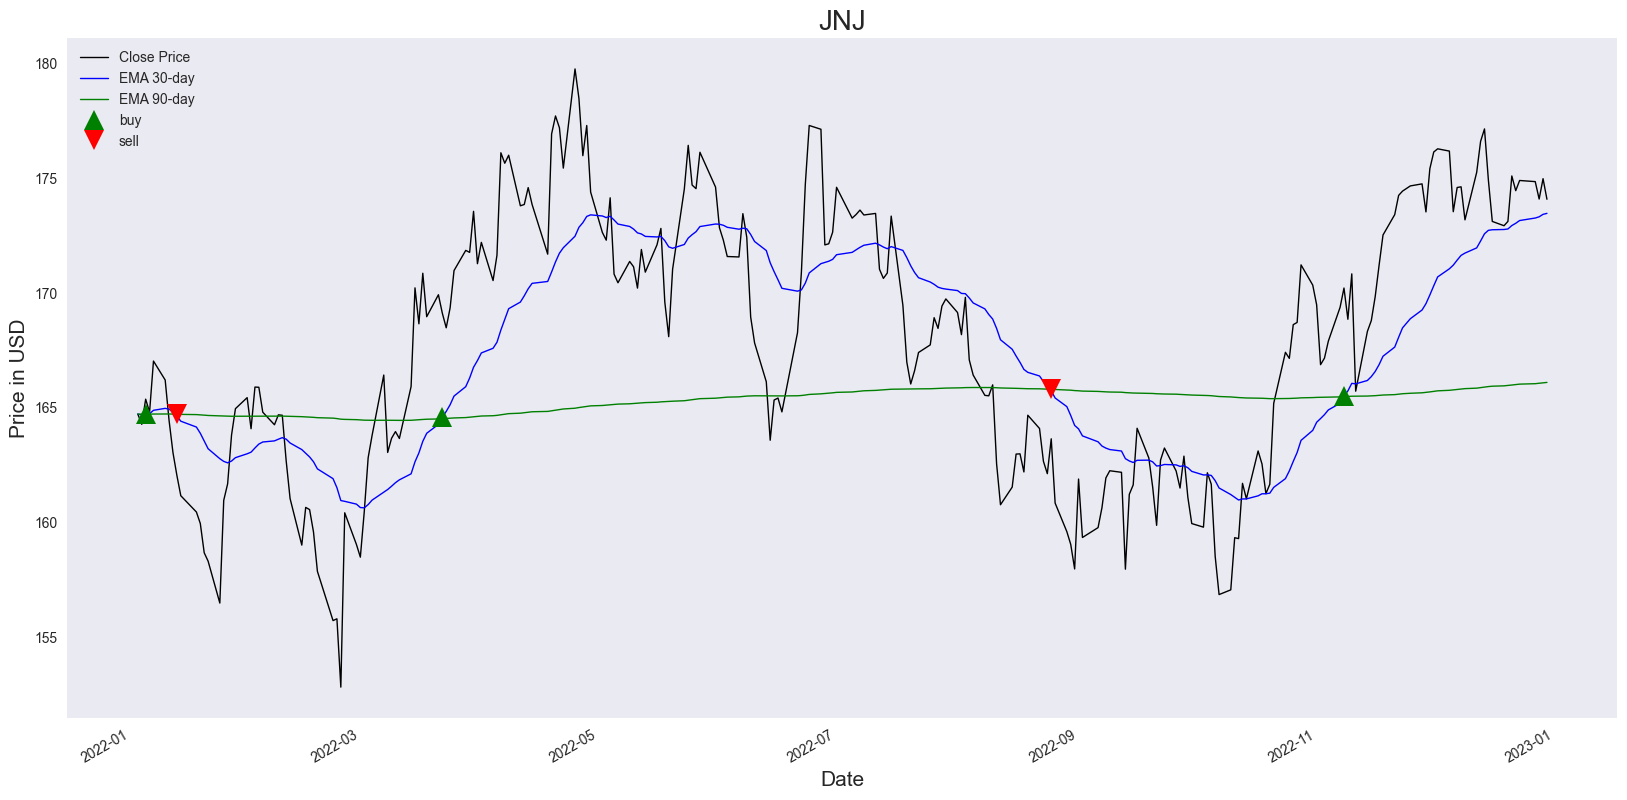

In [16]:
plt.figure(figsize = (20,10))
#plot close price, short-term and long-term moving averages
mydata2['Close Price'].plot(color = 'k', lw = 1, label = 'Close Price') 
mydata2['EMA30'].plot(color = 'b', lw = 1, label='EMA 30-day ')
mydata2['EMA90'].plot(color = 'g', lw = 1, label='EMA 90-day' )
#plot 'buy' and 'sell' signals
plt.plot(mydata2[mydata2[ 'Position'] == 1].index,
mydata2['EMA30'][mydata2[ 'Position'] == 1],
'^', markersize = 15, color = 'g', label='buy')
plt.plot(mydata2[mydata2['Position'] == -1].index,
mydata2['EMA90'][mydata2[ 'Position'] == -1],
'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Price in USD', fontsize = 15 )
plt.xlabel('Date', fontsize = 15)
plt.title(myticker2, fontsize = 20)
plt.legend()
plt.grid()
plt.show()

In [17]:
df_position2 = mydata2[ (mydata2['Position'] == 1) | (mydata2['Position'] == -1)] 
df_position2['Position'] = df_position2['Position'].apply(lambda x: 'Buy' if x == 1 else 'Sell') 
print(tabulate(df_position2, headers = 'keys', tablefmt = 'psql'))

+---------------------+---------------+---------+---------+----------+------------+
| Date                |   Close Price |   EMA30 |   EMA90 |   Signal | Position   |
|---------------------+---------------+---------+---------+----------+------------|
| 2022-01-05 00:00:00 |       165.365 | 164.728 | 164.713 |        1 | Buy        |
| 2022-01-13 00:00:00 |       162.043 | 164.63  | 164.711 |        0 | Sell       |
| 2022-03-22 00:00:00 |       169.113 | 164.581 | 164.514 |        1 | Buy        |
| 2022-08-25 00:00:00 |       163.638 | 165.732 | 165.797 |        0 | Sell       |
| 2022-11-08 00:00:00 |       170.207 | 165.51  | 165.475 |        1 | Buy        |
+---------------------+---------------+---------+---------+----------+------------+


## Forecasting

In [18]:
myticker = "JNJ"
mydata = pd.DataFrame()
mydata[myticker] = yf.download(myticker, start = "2022-01-01", end = "2022-12-31")["Adj Close"]
mydata.columns = {'Close Price'}
mydata.head(10)

[*********************100%***********************]  1 of 1 completed


,Close Price
Date,
2022-01-03,164.712036
2022-01-04,164.270355
2022-01-05,165.364975
2022-01-06,164.798447
2022-01-07,167.026108
2022-01-10,166.200333
2022-01-11,164.433594
2022-01-12,163.031693
2022-01-13,162.042694


In [19]:
mydata = mydata.reset_index()
mydata[['ds','y']] = mydata[['Date','Close Price']]
mydata

,Date,Close Price,ds,y
0,2022-01-03,164.712036,2022-01-03,164.712036
1,2022-01-04,164.270355,2022-01-04,164.270355
2,2022-01-05,165.364975,2022-01-05,165.364975
3,2022-01-06,164.798447,2022-01-06,164.798447
4,2022-01-07,167.026108,2022-01-07,167.026108
...,...,...,...,...
246,2022-12-23,174.893036,2022-12-23,174.893036
247,2022-12-27,174.843750,2022-12-27,174.843750
248,2022-12-28,174.084991,2022-12-28,174.084991
249,2022-12-29,174.971878,2022-12-29,174.971878


In [20]:
model = prophet.Prophet()

In [21]:
prophet_df = mydata.drop(['Date','Close Price'],axis=1)

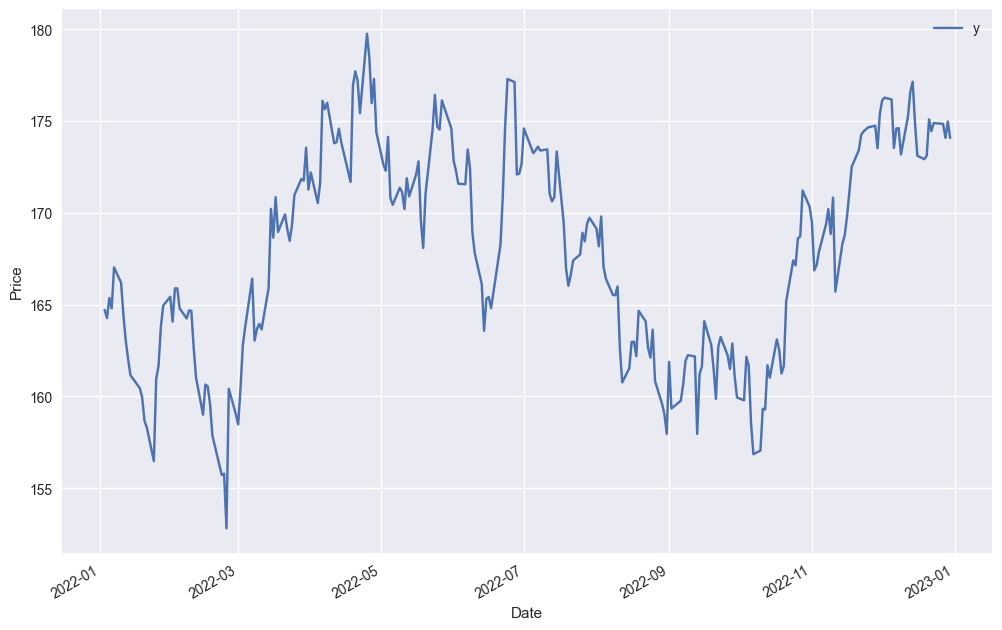

In [22]:
ax = prophet_df.set_index('ds').plot(figsize=(12,8))
ax.set_ylabel('Price')
ax.set_xlabel('Date')
plt.show()

In [23]:
model.fit(prophet_df)

21:31:41 - cmdstanpy - INFO - Chain [1] start processing
21:31:41 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
future = model.make_future_dataframe(periods=365)

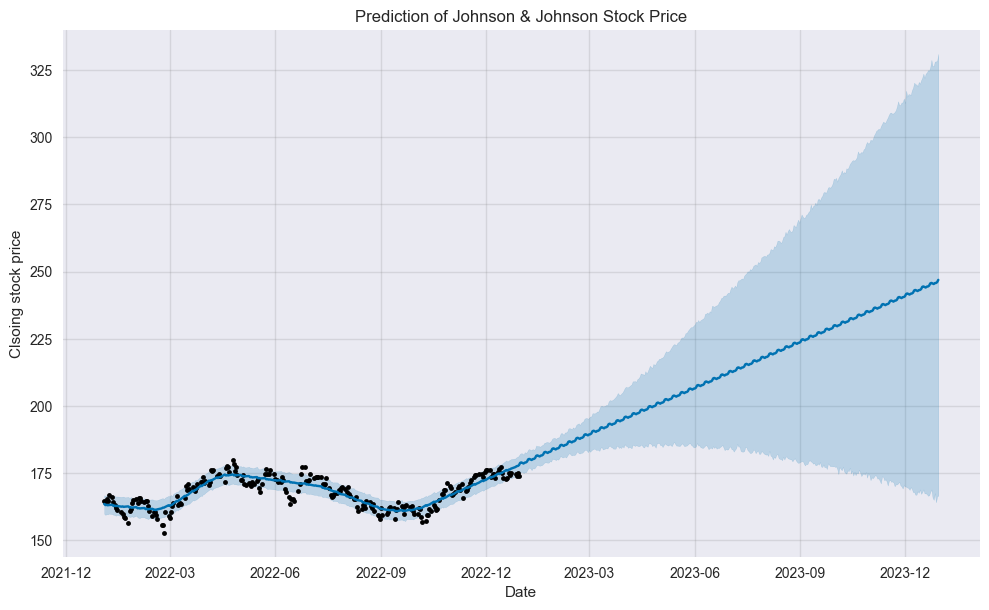

,ds,yhat,yhat_lower,yhat_upper
611,2023-12-26,245.375151,165.065600,326.605437
612,2023-12-27,245.704961,167.527466,328.132986
613,2023-12-28,245.766779,164.140984,328.190815
614,2023-12-29,246.068614,166.474756,328.419789
615,2023-12-30,246.910895,166.588262,330.972908


In [25]:
predictions = model.predict(future)
model.plot(predictions)
plt.title("Prediction of Johnson & Johnson Stock Price")
plt.xlabel("Date")
plt.ylabel("Clsoing stock price")
plt.show()

predictions[['ds','yhat','yhat_lower','yhat_upper']].tail()

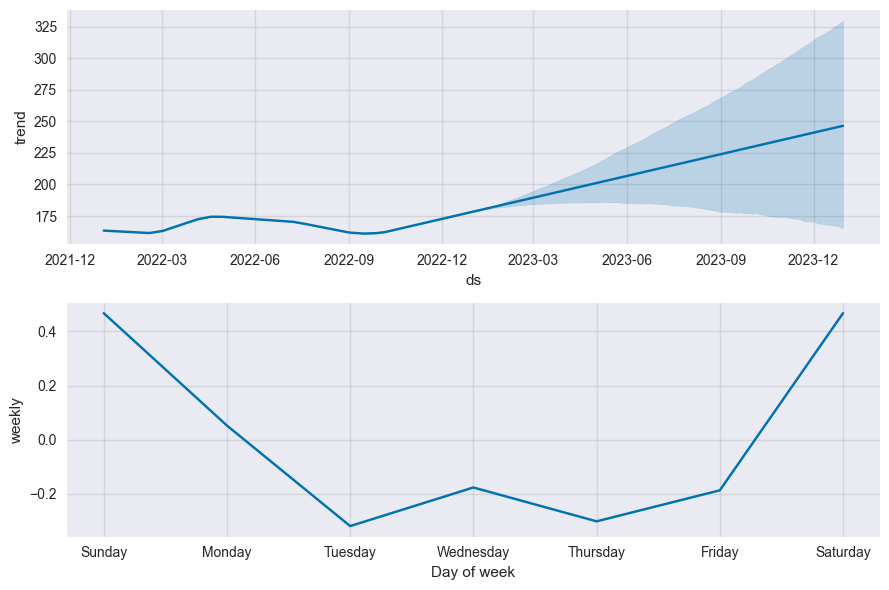

In [26]:
model.plot_components(predictions)
plt.show()

- It appears that the given data represents predicted stock prices for Johnson & Johnson on various dates for the 2023.

- The 'ds' column contains the date for each prediction, and the 'yhat', 'yhat_lower', and 'yhat_upper' columns represent the predicted stock price, lower bound, and upper bound of the predicted stock price, respectively.

- Based on this data, the model predicts that Johnson & Johnson's stock price will increase gradually throughout 2023.

## Recommendation

- According to analysis,Johnson & Johnson may, however, be a decent option for those who are looking to buy and keep it for the long term.